In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
!pip install audtorch
from audtorch.metrics.functional import pearsonr as correlation

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [3]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

train_set = MNIST(
    './', 
    download=True,
    transform=transforms.ToTensor(), 
    train=True
)

test_set = MNIST(
    './', 
    download=True,
    transform=transforms.ToTensor(), 
    train=False
)

--2021-10-09 11:50:05--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-10-09 11:50:06--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.3’

MNIST.tar.gz.3          [             <=>    ]  33.20M  10.5MB/s    in 3.2s    

2021-10-09 11:50:09 (10.5 MB/s) - ‘MNIST.tar.gz.3’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=128, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=128, shuffle=False,drop_last=True)

In [5]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 48, kernel_size=3), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(48, 96, kernel_size=3), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=1, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 10, kernel_size=1), 
        nn.AvgPool2d(kernel_size=8),
    )
  def forward(self, x):
    logits = self.net(x)
    return logits.view(-1, 10)

In [6]:
# Pretrain classifier
classifier = Classifier().cuda()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
for epoch in range(20):
  for i, (x,y) in enumerate(train_loader):
    x, y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    train_loss = loss(classifier(x), y)
    train_loss.backward()
    optimizer.step()
    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Classifier_loss: {}'.format(epoch+1, 20, i+1, len(train_loader), train_loss.item()))

Epoch [1/20], Step [1/468], Classifier_loss: 2.3021578788757324
Epoch [1/20], Step [101/468], Classifier_loss: 1.6581026315689087
Epoch [1/20], Step [201/468], Classifier_loss: 0.661137580871582
Epoch [1/20], Step [301/468], Classifier_loss: 0.462356299161911
Epoch [1/20], Step [401/468], Classifier_loss: 0.18061107397079468
Epoch [2/20], Step [1/468], Classifier_loss: 0.16658711433410645
Epoch [2/20], Step [101/468], Classifier_loss: 0.14329417049884796
Epoch [2/20], Step [201/468], Classifier_loss: 0.11448026448488235
Epoch [2/20], Step [301/468], Classifier_loss: 0.11893320083618164
Epoch [2/20], Step [401/468], Classifier_loss: 0.1720404028892517
Epoch [3/20], Step [1/468], Classifier_loss: 0.2876392602920532
Epoch [3/20], Step [101/468], Classifier_loss: 0.08969510346651077
Epoch [3/20], Step [201/468], Classifier_loss: 0.124814473092556
Epoch [3/20], Step [301/468], Classifier_loss: 0.08815083652734756
Epoch [3/20], Step [401/468], Classifier_loss: 0.0974579006433487
Epoch [4/20]

In [7]:
torch.save(classifier.state_dict(), 'pretrained_classifier.pth')

In [8]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy: %s %%' % (100 * correct / total))

In [9]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    layers = [
              nn.Conv2d(1, 64, 5, padding=2, stride=2), nn.BatchNorm2d(64, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(64, 128, 5, padding=2, stride=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(128, 256, 5, padding=2, stride=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Flatten(), nn.Linear(256*4*4, 2048), nn.BatchNorm1d(2048, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Linear(2048, 10),
    ]
    self.net = nn.Sequential(*layers)

  def forward(self,x):
    return self.net(x)

In [10]:
!pip install audtorch

In [11]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
              nn.Linear(20, 256*4*4), nn.BatchNorm1d(256*4*4, momentum=0.9), nn.LeakyReLU(0.2),
              )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(256,256,6, stride=2, padding=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(256,128,6, stride=2, padding=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128,32,6, stride=2, padding=3), nn.BatchNorm2d(32, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32,1,5, stride=1, padding=3), nn.Tanh()
    )

  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 256, 4, 4)
    return self.conv(x)

In [12]:
class Generator(nn.Module):
  def __init__(self, epsilon):
    super().__init__()
    self.decoder = Decoder()
    self.encoder = Encoder()
    self.classifier = classifier
    self.epsilon = epsilon
    for param in classifier.parameters():
      param.requires_grad = False

  def loss(self, x, y, gen_labels):
    one_hot = F.one_hot(gen_labels, 10).cuda()
    z = torch.cat((self.encoder(x), one_hot), 1)
    perturbation = epsilon * self.decoder(z)
    logits = self.classifier(x+perturbation)
    predictions = F.softmax(logits, 1)
    loss = nn.CrossEntropyLoss()
    return loss(classifier(x+perturbation), gen_labels), perturbation

In [13]:
epsilon = 0.15
epochs = 10
model = Generator(epsilon).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(epochs):
  for i, (x,y) in enumerate(train_loader):
    x,y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    gen_labels = torch.randint(0,10, (128,)).cuda()
    loss, perturbation = model.loss(x,y,gen_labels)
    loss.backward()
    optimizer.step()
    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss.item()))

Epoch [1/10], Step [1/468], Loss: 18.797645568847656
Epoch [1/10], Step [101/468], Loss: 6.8471293449401855
Epoch [1/10], Step [201/468], Loss: 4.194681167602539
Epoch [1/10], Step [301/468], Loss: 4.0504302978515625
Epoch [1/10], Step [401/468], Loss: 3.0289294719696045
Epoch [2/10], Step [1/468], Loss: 2.5090718269348145
Epoch [2/10], Step [101/468], Loss: 2.678927421569824
Epoch [2/10], Step [201/468], Loss: 2.4938299655914307
Epoch [2/10], Step [301/468], Loss: 2.5457727909088135
Epoch [2/10], Step [401/468], Loss: 3.0774600505828857
Epoch [3/10], Step [1/468], Loss: 1.7756413221359253
Epoch [3/10], Step [101/468], Loss: 2.402621030807495
Epoch [3/10], Step [201/468], Loss: 2.16241192817688
Epoch [3/10], Step [301/468], Loss: 2.874807834625244
Epoch [3/10], Step [401/468], Loss: 1.6411018371582031
Epoch [4/10], Step [1/468], Loss: 1.7391899824142456
Epoch [4/10], Step [101/468], Loss: 1.9433387517929077
Epoch [4/10], Step [201/468], Loss: 2.174928903579712
Epoch [4/10], Step [301/4

In [14]:
def adv_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          gen_labels = torch.randint(0,10, (128,)).cuda()
          outputs = net(model.loss(images, labels, gen_labels)[1] + images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Adversarial accuracy: %s %%' % (100 * correct / total))

In [17]:
adv_accuracy(classifier)

Adversarial accuracy: 31.780849358974358 %


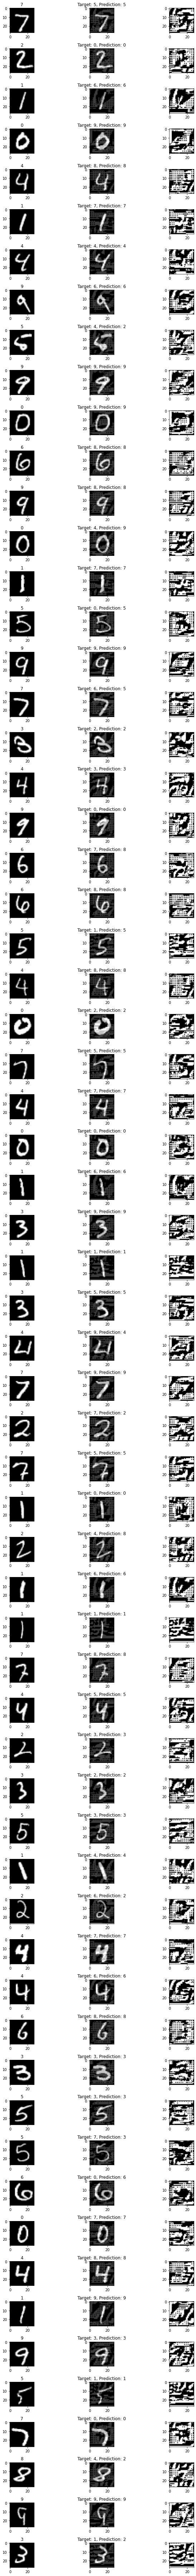

In [21]:
for x,y in test_loader:
  gen_labels = torch.randint(0,10, (128,)).cuda()
  x,y = x.cuda(), y.cuda()
  base_predictions = classifier(x)
  _, perturbations = model.loss(x,y, gen_labels)
  new_predictions = classifier(x+perturbations)
  fig, axs = plt.subplots(64, 3)
  fig.set_figheight(100)
  fig.set_figwidth(10)
  images = []
  for i in range(64):
          image, perturbation = x[i][0].detach().cpu().numpy(), perturbations[i][0].detach().cpu().numpy()
          images.append(axs[i, 0].imshow(image, cmap='gray'))
          axs[i,0].title.set_text(torch.argmax(base_predictions[i]).item())
          images.append(axs[i,1].imshow(image+perturbation, cmap='gray'))
          axs[i,1].title.set_text(f'Target: {gen_labels[i]}, Prediction: {torch.argmax(new_predictions[i]).item()}')
          images.append(axs[i,2].imshow(perturbation, cmap='gray'))
  break

plt.tight_layout()
plt.show()